# Air Pollution Modeling

Modeling atmospheric pollutant dispersion is essential to understand the impact of emissions on air quality and public health. In this study, we focus on an idealized case of air pollution in a two-dimensional domain, subject to a constant wind.

We consider a pollutant whose concentration, denoted $ u(x, y, t) $, evolves under the effect of:
- a uniform wind blowing in the diagonal direction of the domain, that is from the lower left corner to the upper right corner ($ \vec{v} $);
- a diffusion phenomenon modeled by a coefficient $ D > 0 $, representing the dispersion of the pollutant due to turbulence;
- and a pollution source $ f(x, y, t) $, which can be defined in such a way as to guarantee a known exact solution.
\end{itemize}

This type of simplified model allows a better understanding of the transport and diffusion mechanisms at play, while numerically validating the accuracy of a resolution scheme. For this, we adopt a classical approach: the **manufactured solution** method. It consists of choosing a smooth analytical solution $ u(x, y, t) $ that is compatible with the physics of the problem, and then deducing the exact form of the source $ f(x, y, t) $.

We consider the following advection-diffusion problem on the domain $\Omega = [-L_x, L_x]\times[-L_y, L_y]$, with $L_x = L_y = 20 ~km$ and the time interval $[0, T]$:

$$
\begin{cases}
\partial_t c + v \cdot \nabla c - D \Delta c = 0 \quad \text{in } (0, T]\times \Omega \\
c(0, x,y) = c_0(x,y) \quad \text{in } \Omega \\
c(t, x,y) = f(t, x, y) \quad \text{on } \partial([0, T]\times\Omega)
\end{cases}.
$$

with $v = (1.0, 0.5) m/s$ as velocity vector and $D = 0.1 m^2/s$ as diffusion coefficient.

The analytical solution of the problem is given by:

$$
f(t,x,y) = \frac{1}{\pi (4Dt +\sigma^2)} \exp{\left(-\frac{(x-v_xt)^2+(y-v_y t)^2}{4Dt + \sigma^2}\right)}
$$

In our comparative study, we will evaluate these two approaches on the same pollutant dispersion problem to highlight their respective performances in this specific context.


In [3]:
!apt-get update -q
!apt-get install -y libglu1-mesa -q
!pip install gmsh numpy matplotlib meshio -q

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:2 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:3 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:4 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ Packages [75.2 kB]
Get:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:7 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease [18.1 kB]
Get:9 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [2,788 kB]
Get:10 https://r2u.stat.illinois.edu/ubuntu jammy/main all Packages [8,842 kB]
Hit:11 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Get:12 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Hit:13 https://ppa.launchpadcontent.net/ubuntugi

In [4]:
import warnings
warnings.filterwarnings('ignore')

# 1. Crouzeix-Raviart with Backward Euler Scheme

In [5]:
%%writefile crbe_fem.py
# Crouzeix-Raviart FEM with Backward Euler for Advection-Diffusion Equation


import meshio
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.tri as mtri
import gmsh
import sys
import time
from tqdm import tqdm
import os
from scipy.sparse import csr_matrix, lil_matrix
from scipy.sparse.linalg import spsolve


def create_mesh(n_points_per_axis=20, domain_size=2.0, filename="square_mesh.msh"):
    """Create a square mesh using GMSH API."""
    
    # Initialize Gmsh
    gmsh.initialize()
    gmsh.model.add("rectangle")
    
    # Parameters of the rectangle
    Lx = Ly = 2*domain_size # Width and height
    x0 = y0 = -domain_size      # Bottom-left corner
    
    # Create rectangle using a built-in function
    gmsh.model.occ.addRectangle(x0, y0, 0, Lx, Ly)
    
    # Synchronize to create the CAD entities
    gmsh.model.occ.synchronize()
    
    # Mesh size (can also define fields for variable mesh)
    mesh_size = (2 * domain_size) / (n_points_per_axis-1)
    gmsh.option.setNumber("Mesh.CharacteristicLengthMin", mesh_size)
    gmsh.option.setNumber("Mesh.CharacteristicLengthMax", mesh_size)
    
    # Generate 2D mesh
    gmsh.model.mesh.generate(2)
    
    # Save mesh file
    gmsh.write(filename)
    
    # Finalize Gmsh
    gmsh.finalize()
    return filename


class DomainParams:
    """Parameters defining the domain of the problem."""
    
    def __init__(self, Lx, Ly, T):
        """Initialize domain parameters."""
        self.Lx = Lx
        self.Ly = Ly
        self.T = T

    def is_boundary(self, x):
        """Check if points are on boundary."""
        is_left = np.isclose(x[:, 0], -self.Lx)
        is_right = np.isclose(x[:, 0], self.Lx)
        is_bottom = np.isclose(x[:, 1], -self.Ly)
        is_top = np.isclose(x[:, 1], self.Ly)
        return is_left | is_right | is_bottom | is_top


class Models:
    """Physical model definitions and analytical solution."""
    
    def __init__(self, vx, vy, D, sigma):
        """Initialize model parameters."""
        self.vx = vx
        self.vy = vy
        self.D = D
        self.sigma = sigma

    def analytical_solution(self, xyt):
        """Compute analytical solution at space-time points."""
        # Handle t=0 case separately to avoid division by zero
        t_zero_mask = xyt[:,2] == 0
        result = np.zeros_like(xyt[:,0])
        
        # For t=0 points
        if np.any(t_zero_mask):
            denom_zero = self.sigma**2
            term_zero = np.exp(
                - (xyt[t_zero_mask,0]**2 + xyt[t_zero_mask,1]**2) / denom_zero
            )
            result[t_zero_mask] = term_zero / (np.pi * denom_zero)
        
        # For t>0 points
        if np.any(~t_zero_mask):
            denom = 4 * self.D * xyt[~t_zero_mask,2] + self.sigma**2
            term = np.exp(
                - ((xyt[~t_zero_mask,0] - xyt[~t_zero_mask,2] * self.vx)**2 + 
                   (xyt[~t_zero_mask,1] - xyt[~t_zero_mask,2] * self.vy)**2) / denom
            )
            result[~t_zero_mask] = term / (np.pi * denom)
            
        return result

    def grad_analytical_solution(self, xyt):
        """Compute gradient of analytical solution."""
        # Handle t=0 case separately
        t_zero_mask = xyt[:,2] == 0
        du_dx = np.zeros_like(xyt[:,0])
        du_dy = np.zeros_like(xyt[:,0])
        
        # For t=0 points
        if np.any(t_zero_mask):
            denom_zero = self.sigma**2
            u_zero = self.analytical_solution(xyt[t_zero_mask])
            du_dx[t_zero_mask] = -2 * xyt[t_zero_mask,0] * u_zero / denom_zero
            du_dy[t_zero_mask] = -2 * xyt[t_zero_mask,1] * u_zero / denom_zero
        
        # For t>0 points
        if np.any(~t_zero_mask):
            denom = 4 * self.D * xyt[~t_zero_mask,2] + self.sigma**2
            u = self.analytical_solution(xyt[~t_zero_mask])
            du_dx[~t_zero_mask] = -2 * (xyt[~t_zero_mask,0] - xyt[~t_zero_mask,2] * self.vx) * u / denom
            du_dy[~t_zero_mask] = -2 * (xyt[~t_zero_mask,1] - xyt[~t_zero_mask,2] * self.vy) * u / denom
            
        return du_dx, du_dy

    def initial_condition_fn(self, xy):
        """Evaluate initial condition."""
        t = np.zeros((xy.shape[0], 1))
        xyt = np.hstack([xy, t])
        return self.analytical_solution(xyt)


class MeshData:
    """Class for storing and processing mesh data."""
    
    def __init__(self, mesh, domain_params, nt):
        """Initialize mesh data."""
        self.mesh = mesh
        self.domain_params = domain_params
        self.nt = nt

        self.time_discr = np.linspace(0, domain_params.T, nt)

        # Points
        self.points = mesh.points[:,:2]
        self.number_of_points = len(self.points)

        # Triangles
        self.triangles = mesh.cells_dict['triangle']
        self.number_of_triangles = len(self.triangles)

        # Segments and mapping
        self.segments, self.triangle_to_segments = self._enumerate_segments()
        self.number_of_segments = len(self.segments)

        # Midpoints
        self.midpoints = (self.points[self.segments[:, 0]] + self.points[self.segments[:, 1]]) / 2.0

        # Compute geometry
        self.segment_lengths = self._compute_segment_lengths()
        self.triangle_areas = self._compute_triangle_areas()

        # Boundary Segments
        segments_flat = self.triangle_to_segments.flatten()
        uniques, counts = np.unique(segments_flat, return_counts=True)
        self.boundary_segments = uniques[counts == 1]

        # Boundary triangles
        self.boundary_triangles = None
        self.boundary_triangle_to_segments = {}

        triangles_with_boundary = []
        
        for idx, triangle_segments in enumerate(self.triangle_to_segments):
            for segment in triangle_segments:
                if segment in self.boundary_segments:
                    triangles_with_boundary.append(idx)
                    self.boundary_triangle_to_segments[idx] = segment
                    break
                    
        self.boundary_triangles = np.array(triangles_with_boundary, dtype=np.int32)

        self.diameter = 0
        for v1, v2, v3 in self.triangles:
            p1 = self.points[v1]
            p2 = self.points[v2]
            p3 = self.points[v3]
            h = max(
                np.linalg.norm(p1 - p2),
                np.linalg.norm(p2 - p3),
                np.linalg.norm(p3 - p1)
            )
            if self.diameter < h:
                self.diameter = h

    
    def _enumerate_segments(self):
        """Enumerate all segments in the mesh."""
        segment_map = {}
        triangle_to_segments = []
        segment_id = 0

        for tri in self.triangles:
            tri_segments = []
            edges = [(tri[1], tri[2]), (tri[2], tri[0]), (tri[0], tri[1])]

            for a, b in edges:
                edge = tuple(sorted((a, b)))
                if edge not in segment_map:
                    segment_map[edge] = segment_id
                    segment_id += 1
                tri_segments.append(segment_map[edge])

            triangle_to_segments.append(tri_segments)

        segments = np.array(list(segment_map.keys()), dtype=np.int32)
        triangle_to_segments = np.array(triangle_to_segments, dtype=np.int32)

        return segments, triangle_to_segments
    

    def _compute_segment_lengths(self):
        """Compute the length of each segment.        """
        p = self.points
        lengths = []
        for a, b in self.segments:
            length = np.linalg.norm(p[a] - p[b])
            lengths.append(length)
        return np.array(lengths, dtype=np.float64)

    def _compute_triangle_areas(self):
        """Compute the area of each triangle. """
        p = self.points
        areas = []
        for i, j, k in self.triangles:
            # Use determinant-based formula for triangle area
            x1, y1 = p[i]
            x2, y2 = p[j]
            x3, y3 = p[k]
            area = 0.5 * abs((x2 - x1)*(y3 - y1) - (x3 - x1)*(y2 - y1))
            areas.append(area)
        return np.array(areas, dtype=np.float64)

    def show(self):
        # Créer la figure
        plt.figure(figsize=(10, 8))
        plt.triplot(self.points[:, 0], self.points[:, 1], self.triangles)
        plt.axis('equal')
        plt.grid(True)
        plt.title('Visualisation du maillage 2D')
        plt.show()


class BESCRFEM:  # Backward Euler Scheme and Crouzeix-Raviart Finite Element Methods
    """Implementation of Backward Euler scheme with Crouzeix-Raviart FEM."""
    
    def __init__(self, domain_params, model_params, mesh_data, use_quadrature=False):
        """Initialize solver."""
        self.domain_params = domain_params
        self.model_params = model_params
        self.mesh_data = mesh_data
        self.dt = domain_params.T / (mesh_data.nt - 1)

        # Reference Matrices
        self.triangle_grad_phis = np.array([
            [2.0, 2.0],
            [-2.0, 0.0],
            [0.0, -2.0]
        ], dtype=np.float64)

        # ==== Quadrature d'ordre 5 sur l'élément de référence ====
        if use_quadrature:
            self._compute_reference_element_matrices_order5()
        else:
            self._compute_reference_element_matrices()

    def _compute_reference_element_matrices(self):
        # ==== Stiffness Matrix ====
            self.reference_stiffness = np.array([
                [4.0, -2.0, -2.0],
                [-2.0, 2.0, 0.0],
                [-2.0, 0.0, 2.0]
            ], dtype=np.float64)
        
            # ==== Mass Matrix =====
            self.reference_mass = np.array([
                [1, 0, 0],
                [1, 1, 0],
                [0, 0, 1]
            ]) / 6.0

    def _compute_reference_element_matrices_order5(self):
        """Calcule mass, stiffness et advection locales via une quadrature de degré 5."""
        import numpy as np, math
        # Règle de Hammer-Stroud d'ordre 5 sur triangle de référence (0,0),(1,0),(0,1)
        sqrt15 = math.sqrt(15.0)
        # barycentriques transformées en (x,y)
        a1 = (6 + sqrt15) / 21
        b1 = (9 - 2*sqrt15) / 21
        a2 = (6 - sqrt15) / 21
        b2 = (9 + 2*sqrt15) / 21
        pts = np.array([
            [1/3,    1/3   ],
            [a1,     a1    ],
            [a1,     b1    ],
            [b1,     a1    ],
            [a2,     a2    ],
            [a2,     b2    ],
            [b2,     a2    ]
        ])
        wts = np.array([
            9/80,
            (155+sqrt15)/2400,
            (155+sqrt15)/2400,
            (155+sqrt15)/2400,
            (155-sqrt15)/2400,
            (155-sqrt15)/2400,
            (155-sqrt15)/2400
        ])
        # Fonctions de forme CR sur l'élément de référence
        phis = [
            lambda x,y: -1 + 2*x + 2*y,
            lambda x,y:  1 - 2*x,
            lambda x,y:  1 - 2*y
        ]
        grads = np.array([[2,2],[-2,0],[0,-2]], dtype=float)

        # Initialisation
        M_ref = np.zeros((3,3))
        K_ref = np.zeros((3,3))
        A_ref = np.zeros((3,3))
        vx, vy = self.model_params.vx, self.model_params.vy

        # Boucle de quadrature
        for (xi, yi), w in zip(pts, wts):
            phi_vals = np.array([phi(xi, yi) for phi in phis])
            for i in range(3):
                for j in range(3):
                    # masse
                    M_ref[i,j] += w * phi_vals[i] * phi_vals[j]
                    # rigidité (stiffness)
                    K_ref[i,j] += w * np.dot(grads[i], grads[j])
                    # advection
                    v_dot_grad = vx*grads[i,0] + vy*grads[i,1]
                    A_ref[i,j] += w * v_dot_grad * phi_vals[j]

        # Stockage
        self.reference_mass      = M_ref
        self.reference_stiffness = K_ref
        self.reference_advection = A_ref

    def compute_stiffness_CR(self, tri_idx):
        """Compute local stiffness matrix for Crouzeix-Raviart element."""
        vertices = self.mesh_data.points[
            self.mesh_data.triangles[tri_idx]
        ]

        # compute jacobian of the transformation
        A_tri = (vertices[1:, :] - vertices[0, :]).T

        # compute the jacobian's inverse
        B_tri = np.linalg.solve(A_tri, np.eye(2))
        
        # compute B_T^T * B_T for the transformed gradients
        BTB = B_tri.T @ B_tri

        # compute local stiffness matrix for current element
        K_local = self.triangle_grad_phis @ BTB @ self.triangle_grad_phis.T        
        return self.model_params.D * self.mesh_data.triangle_areas[tri_idx] * K_local

    def compute_mass_CR(self, tri_idx):
        """Compute local mass matrix for Crouzeix-Raviart element."""
        return self.reference_mass * 2 * self.mesh_data.triangle_areas[tri_idx]

    def compute_advection_CR(self, tri_idx):
        # 1) géométrie
        verts = self.mesh_data.points[self.mesh_data.triangles[tri_idx]]
        A_tri = (verts[1:] - verts[0]).T
        B_tri = np.linalg.solve(A_tri, np.eye(2))        # J^{-1}
        # gradient physique (3×2)
        grad_phi = (B_tri.T @ self.triangle_grad_phis.T).T
    
        # 2) terme ∫ φ_i (v·∇φ_j) dx = (area/3) * (v·∇φ_j)
        area     = self.mesh_data.triangle_areas[tri_idx]
        phi_int  = np.ones(3) * (area / 3.0)             # φ intégrée
        v_vec    = np.array([self.model_params.vx, self.model_params.vy])
        v_dot_gr = grad_phi @ v_vec                      # (3,)
        A_loc    = np.outer(phi_int, v_dot_gr)           # (3×3)
        return 2 * A_loc

        
    def build_global_matrices(self):
        """Build global mass, stiffness and advection matrices via triplet assembly."""
        n_seg = self.mesh_data.number_of_segments
        # listes de triplets pour chacune des matrices
        I_m, J_m, V_m = [], [], []
        I_k, J_k, V_k = [], [], []
        I_a, J_a, V_a = [], [], []

        # boucle sur chaque triangle
        for tri_idx in range(self.mesh_data.number_of_triangles):
            segs = self.mesh_data.triangle_to_segments[tri_idx].tolist()  # [i0,i1,i2]
            M_loc = self.compute_mass_CR(tri_idx)
            K_loc = self.compute_stiffness_CR(tri_idx)
            A_loc = self.compute_advection_CR(tri_idx)

            # assemble local -> global
            for a in range(3):
                i = segs[a]
                for b in range(3):
                    j = segs[b]
                    I_m.append(i); J_m.append(j); V_m.append(M_loc[a, b])
                    I_k.append(i); J_k.append(j); V_k.append(K_loc[a, b])
                    I_a.append(i); J_a.append(j); V_a.append(A_loc[a, b])

        # construction des sparse CSR
        self.global_mass      = csr_matrix((V_m, (I_m, J_m)), shape=(n_seg, n_seg))
        self.global_stiffness = csr_matrix((V_k, (I_k, J_k)), shape=(n_seg, n_seg))
        self.global_advection = csr_matrix((V_a, (I_a, J_a)), shape=(n_seg, n_seg))

        # build system matrix once (sans BC)
        self.base_system = self.global_mass.copy() / self.dt \
                         + self.global_advection       \
                         + self.global_stiffness

    
    def set_initial_condition(self):
        """
        Set initial condition.
        """
        self.u_prev = self.model_params.initial_condition_fn(self.mesh_data.midpoints)

    def set_source_term(self, tt):
        # Quadrature d'ordre 5 sur [0, 1] pour segment
        quad_pts_1d = np.array([
            0.5 - np.sqrt(5 + 2*np.sqrt(10/7))/6,
            0.5 - np.sqrt(5 - 2*np.sqrt(10/7))/6,
            0.5,
            0.5 + np.sqrt(5 - 2*np.sqrt(10/7))/6,
            0.5 + np.sqrt(5 + 2*np.sqrt(10/7))/6
        ])

        quad_wts_1d = np.array([
            0.2369268851,
            0.4786286705,
            0.5688888889,
            0.4786286705,
            0.2369268851
        ])

        # 1) Second membre non modifié : M/dt * u^n
        b = self.global_mass.dot(self.u_prev) / self.dt

        # 2) Copier base_system et passer en LIL pour poser les BC
        A = self.base_system.copy().tolil()

        # 3) Imposer Dirichlet sur chaque segment frontière

        for seg in self.mesh_data.boundary_segments:
            # Récupération des extrémités du segment
            p0, p1 = self.mesh_data.points[
                self.mesh_data.segments[seg],:
            ]  # (2,) chacun
            

            # Coordonnées physiques des points de quadrature sur le segment
            seg_pts = np.outer(1 - quad_pts_1d, p0) + np.outer(quad_pts_1d, p1)  # (5, 2)
            xyt = np.hstack((seg_pts, np.full((5,1), tt)))  # (5, 3)

            # Évaluer la condition de Dirichlet au temps t
            vals = np.array([self.model_params.analytical_solution(pt.reshape(1,3)).item() for pt in xyt])
            
            # Intégrale approchée sur le segment (longueur * somme pondérée)
            seg_len = np.linalg.norm(p1 - p0)
            bc_val = np.dot(vals, quad_wts_1d) * seg_len  # approximation intégrale
            
            # Normaliser par la longueur du segment pour obtenir une moyenne pondérée
            bc_val /= np.sum(quad_wts_1d) * seg_len

            # Imposer la condition comme avant
            A.rows[seg] = [seg]
            A.data[seg] = [1.0]
            b[seg] = bc_val
        
        return A.tocsr(), b

    def solve(self):
        """  
        Schéma de Backward Euler + FEM CR :
        - assemble une fois base_system via build_global_matrices()
        - à chaque pas : set_source_term(t) → (A,b), puis spsolve
        """
        # 1) Initial condition and storage
        self.set_initial_condition()  
        n_steps    = self.mesh_data.nt
        n_segments = self.mesh_data.number_of_segments
        self.solutions = np.zeros((n_steps, n_segments))
        self.solutions[0, :] = self.u_prev

        # 2) Assemble global matrices and base system (sans BC)
        self.build_global_matrices()  
        # build_global_matrices doit avoir défini self.base_system

        # 3) Time‐stepping loop
        start = time.time()
        for step in tqdm(range(1, n_steps), desc="Time‐stepping"):
            t = step * self.dt

            # récupérer A, b au pas t
            A, b = self.set_source_term(t)

            # résoudre (M/dt + A + K) u^{n+1} = b
            self.u_prev = spsolve(A, b)
            self.solutions[step, :] = self.u_prev

        # 4) Reporting
        self.solve_time = time.time() - start
        print(f"Solve completed in {self.solve_time:.2f}s")

        return self.solutions

    
    def compute_errors(self):
        """Compute errors between numerical and analytical solutions."""
        n_steps = self.mesh_data.nt
        n_segments = self.mesh_data.number_of_segments
        
        # Initialize error metrics
        l2_errors = np.zeros(n_steps)
        linf_errors = np.zeros(n_steps)
        
        # For each time step, compute errors
        for i in range(n_steps):
            t = i * self.dt
            
            # Get numerical solution at this time step
            numerical_sol = self.solutions[i, :]
            
            # Compute analytical solution at midpoints at time t
            midpoints = self.mesh_data.midpoints
            t_array = np.full((n_segments, 1), t)
            xyt = np.hstack([midpoints, t_array])
            analytical_sol = self.model_params.analytical_solution(xyt)
            
            # Compute error
            error = numerical_sol - analytical_sol
            
            # Compute segment volumes (areas) for L2 norm
            segment_volumes = self.mesh_data.segment_lengths / 2  # Half-length for 1D segments
            
            # Compute L2 error (weighted by segment volumes)
            l2_errors[i] = np.sqrt(np.sum(error**2 * segment_volumes) / np.sum(segment_volumes))
            
            # Compute L∞ error
            linf_errors[i] = np.max(np.abs(error))
        
        return {
            'l2_errors': l2_errors,
            'linf_errors': linf_errors,
            'final_l2_error': l2_errors[-1],
            'final_linf_error': linf_errors[-1]
        }

    def plot_solution(self, time_index=None, save_dir="results"):
        """Plot solution at specified time index."""
        if time_index is None:
            time_index = self.mesh_data.nt - 1
        
        t = time_index * self.dt
        
        # Create directory if it doesn't exist
        os.makedirs(save_dir, exist_ok=True)
        
        # # Get points and triangles
        # points = self.mesh_data.points
        # triangles = self.mesh_data.triangles
        midpoints = self.mesh_data.midpoints
        triangle_to_segments = self.mesh_data.triangle_to_segments
        
        # Get numerical solution at the specified time index
        numerical_midpoint_values = self.solutions[time_index]
        
        # Compute analytical solution at vertices
        t_array = np.full((len(midpoints), 1), t)
        xyt = np.hstack([midpoints, t_array])
        analytical_midpoint_values = self.model_params.analytical_solution(xyt)
        
        # Error at vertices
        error_values = numerical_midpoint_values - analytical_midpoint_values
        
        # Create subplot
        fig, axs = plt.subplots(1, 3, figsize=(18, 6))
        
        # Plot numerical solution
        triang = mtri.Triangulation(midpoints[:, 0], midpoints[:, 1], triangle_to_segments)
        cntr1 = axs[0].tricontourf(triang, numerical_midpoint_values, 20, cmap="viridis")
        axs[0].set_title(f"Numerical Solution at t = {t:.3f}")
        axs[0].set_xlabel("x")
        axs[0].set_ylabel("y")
        fig.colorbar(cntr1, ax=axs[0])
        
        # Plot analytical solution
        cntr2 = axs[1].tricontourf(triang, analytical_midpoint_values, 20, cmap="viridis")
        axs[1].set_title(f"Analytical Solution at t = {t:.3f}")
        axs[1].set_xlabel("x")
        axs[1].set_ylabel("y")
        fig.colorbar(cntr2, ax=axs[1])
        
        # Plot error
        cntr3 = axs[2].tricontourf(triang, error_values, 20, cmap="coolwarm", 
                                   norm=plt.Normalize(-np.max(np.abs(error_values)), 
                                                    np.max(np.abs(error_values))))
        axs[2].set_title(f"Error at t = {t:.3f}")
        axs[2].set_xlabel("x")
        axs[2].set_ylabel("y")
        fig.colorbar(cntr3, ax=axs[2])
        
        plt.tight_layout()
        plt.savefig(f"{save_dir}/solution_t{time_index}.png", dpi=300)
        plt.close()

    def plot_error_evolution(self, errors, save_dir="results"):
        """Plot error evolution over time."""
        os.makedirs(save_dir, exist_ok=True)
        
        time_values = np.linspace(0, self.domain_params.T, self.mesh_data.nt)
        
        plt.figure(figsize=(10, 6))
        plt.semilogy(time_values, errors['l2_errors'], 'b-', label="L2 Error")
        plt.semilogy(time_values, errors['linf_errors'], 'r-', label="L∞ Error")
        plt.grid(True)
        plt.xlabel("Time")
        plt.ylabel("Error (log scale)")
        plt.title("Error Evolution")
        plt.legend()
        plt.tight_layout()
        plt.savefig(f"{save_dir}/error_evolution.png", dpi=300)
        plt.close()

    def visualize_solution(self, step_idx=None):
        """
        Visualiser la solution pour un pas de temps donné
        """
        if step_idx is None:
            step_idx = self.mesh_data.nt - 1  # Visualiser la dernière étape par défaut

        # Convertir les points du maillage en arrays numpy
        points = self.mesh_data.points
        triangles = self.mesh_data.triangles
        
        # Pour visualiser la solution sur les triangles, nous interpolons la solution
        # des milieux des segments vers les sommets des triangles
        vertex_values = np.zeros(len(points))
        vertex_counts = np.zeros(len(points))

        # Pour chaque segment, ajouter sa valeur aux sommets correspondants
        for i, (a, b) in enumerate(self.mesh_data.segments):
            vertex_values[a] += self.solutions[step_idx, i]
            vertex_values[b] += self.solutions[step_idx, i]
            vertex_counts[a] += 1
            vertex_counts[b] += 1

        # Moyenner les valeurs
        vertex_values /= np.maximum(vertex_counts, 1)

        # Créer la figure
        fig, ax = plt.subplots(figsize=(10, 8))

        # Créer une triangulation pour la visualisation
        triang = mtri.Triangulation(points[:, 0], points[:, 1], triangles)

        # Tracer la solution
        contour = ax.tricontourf(triang, vertex_values, cmap='viridis')
        plt.colorbar(contour, ax=ax, label='Concentration')

        # Ajouter un titre avec le temps
        t = step_idx * self.dt
        ax.set_title(f'Solution at t = {t:.2f} s')
        ax.set_xlabel('x [m]')
        ax.set_ylabel('y [m]')

        plt.tight_layout()
        return fig

    def plot_interpoleted_solution(self, time_index=None, save_dir="results"):
        """
        Plot solution at specified time index.
        
        Parameters:
        -----------
        time_index: int or None
            Time index to plot. If None, plot final time.
        save_dir: str
            Directory to save plots
        """
        if time_index is None:
            time_index = self.mesh_data.nt - 1
        
        t = time_index * self.dt
        
        # Create directory if it doesn't exist
        os.makedirs(save_dir, exist_ok=True)
        
        # Get points and triangles
        points = self.mesh_data.points
        triangles = self.mesh_data.triangles
        
        # Get numerical solution at the specified time index
        numerical_sol = self.solutions[time_index]
        
        # Map segment values to vertices for plotting
        vertex_values = np.zeros(len(points))
        count = np.zeros(len(points))
        
        for i, (a, b) in enumerate(self.mesh_data.segments):
            vertex_values[a] += numerical_sol[i]
            vertex_values[b] += numerical_sol[i]
            count[a] += 1
            count[b] += 1
        
        # Average values at vertices
        vertex_values /= np.maximum(count, 1)  # Avoid division by zero
        
        # Compute analytical solution at vertices
        # t_tensor = torch.full((len(points), 1), t, device=device)
        # xyt = torch.cat([self.mesh_data.points, t_tensor], dim=1)
        # analytical_vertex_values = self.model_params.analytical_solution(xyt).cpu().numpy()
        # Compute analytical solution at vertices
        t_array = np.full((len(points), 1), t)
        xyt = np.hstack([points, t_array])
        analytical_vertex_values = self.model_params.analytical_solution(xyt)

        
        # Error at vertices
        error_values = vertex_values - analytical_vertex_values
        
        # Create subplot
        fig, axs = plt.subplots(1, 3, figsize=(18, 6))
        
        # Plot numerical solution
        triang = mtri.Triangulation(points[:, 0], points[:, 1], triangles)
        cntr1 = axs[0].tricontourf(triang, vertex_values, 20, cmap="viridis")
        axs[0].set_title(f"Numerical Solution at t = {t:.3f}")
        axs[0].set_xlabel("x")
        axs[0].set_ylabel("y")
        fig.colorbar(cntr1, ax=axs[0])
        
        # Plot analytical solution
        cntr2 = axs[1].tricontourf(triang, analytical_vertex_values, 20, cmap="viridis")
        axs[1].set_title(f"Analytical Solution at t = {t:.3f}")
        axs[1].set_xlabel("x")
        axs[1].set_ylabel("y")
        fig.colorbar(cntr2, ax=axs[1])
        
        # Plot error
        cntr3 = axs[2].tricontourf(triang, error_values, 20, cmap="coolwarm", 
                                   norm=plt.Normalize(-np.max(np.abs(error_values)), 
                                                    np.max(np.abs(error_values))))
        axs[2].set_title(f"Error at t = {t:.3f}")
        axs[2].set_xlabel("x")
        axs[2].set_ylabel("y")
        fig.colorbar(cntr3, ax=axs[2])
        
        plt.tight_layout()
        plt.savefig(f"{save_dir}/solution_t{time_index}.png", dpi=300)
        plt.close()


def convergence_analysis(domain_params, model_params, domain_size, mesh_sizes, nt_values, save_dir="results"):
    """Perform convergence analysis."""
    # Create directory if it doesn't exist
    os.makedirs(save_dir, exist_ok=True)
    
    # Initialize results storage
    results = []
    
    # Loop over mesh sizes and time steps
    for mesh_size in mesh_sizes:
        for nt in nt_values:
            print(f"Running with mesh size {mesh_size} and {nt} time steps")
            
            # Create mesh
            mesh_file = create_mesh(n_points_per_axis=mesh_size, domain_size=domain_size)
            mesh = meshio.read(mesh_file)
            
            # Setup mesh data
            mesh_data = MeshData(mesh, domain_params, nt)
            
            # Initialize solver
            solver = BESCRFEM(domain_params, model_params, mesh_data)
            
            # Solve
            solver.solve()
            
            # Compute errors
            errors = solver.compute_errors()
            
            # Save results
            result = {
                'mesh_size': mesh_size,
                'nt': nt,
                'h': (2 * domain_size) / (mesh_size - 1),  # Approximate element size
                'dt': domain_params.T / (nt - 1),
                'l2_error': errors['final_l2_error'],
                'linf_error': errors['final_linf_error'],
                'compute_time': solver.solve_time
            }
            results.append(result)
            
            # Plot final solution
            solver.plot_solution(save_dir=f"{save_dir}/mesh{mesh_size}_nt{nt}")
            
            # Plot error evolution
            solver.plot_error_evolution(errors, save_dir="results")


class BESCRFEMUpwind(BESCRFEM):
    """
    Sous-classe de BESCRFEM introduisant plusieurs schémas d'upwind pour la convection.

    Paramètres supplémentaires:
    - upwind_type: 'centered' (pas d'upwind), 'edge_upwind' (flux upstream), 'SUPG' (Petrov-Galerkin)
    """
    def __init__(self, domain_params, model_params, mesh_data, upwind_type='edge_upwind'):
        super().__init__(domain_params, model_params, mesh_data)
        self.upwind_type = upwind_type.lower()

    def compute_advection_CR(self, tri_idx):
        if self.upwind_type == 'centered':
            return super().compute_advection_CR(tri_idx)
        elif self.upwind_type == 'edge_upwind':
            return self._compute_edge_upwind(tri_idx)
        elif self.upwind_type == 'supg':
            return self._compute_supg(tri_idx)
        else:
            raise ValueError(f"Unknown upwind_type: {self.upwind_type}")

    def _compute_edge_upwind(self, tri_idx):
        """
        Upwind simple par flux sur chaque arête (first-order upwind).
        Contribution locale diagonale: sum_e max(v·n_e,0)*|e|.
        """
        pts = self.mesh_data.points[self.mesh_data.triangles[tri_idx]]  # (3,2)
        v = np.array([self.model_params.vx, self.model_params.vy])
        # liste des arêtes locales (indice i correspond à arête opposée au noeud i)
        edges = [(pts[1], pts[2]), (pts[2], pts[0]), (pts[0], pts[1])]
        A_loc = np.zeros((3,3))
        for i, (p, q) in enumerate(edges):
            # vecteur arête
            e = q - p
            # normal non orienté
            n = np.array([e[1], -e[0]])
            # normalisation par longueur
            length = np.linalg.norm(e)
            if length == 0:
                continue
            n_unit = n / length
            # flux positif (inflow si v·n>0)
            flux = max(np.dot(v, n_unit), 0.0)
            # upwind matrix diag
            A_loc[i,i] += flux * length
        return A_loc

    def _compute_supg(self, tri_idx):
        """
        Stabilisation SUPG: on ajoute tau * (v·∇φ_i)(v·∇φ_j) * |K|.
        tau = h / (2|v|), avec h = 2*area / perimeter
        """
        # jacobien et aire
        verts = self.mesh_data.points[self.mesh_data.triangles[tri_idx]]
        A_tri = (verts[1:] - verts[0]).T
        area = self.mesh_data.triangle_areas[tri_idx]
        # calcul de h via périmètre
        perim = 0.0
        for a,b in [(1,2),(2,0), (0,1)]:
            perim += np.linalg.norm(verts[b] - verts[a])
        h = 2*area / perim if perim>0 else 0.0
        v = np.array([self.model_params.vx, self.model_params.vy])
        vnorm = np.linalg.norm(v)
        tau = h / (2*vnorm) if vnorm>0 else 0.0
        # gradients physiques
        B_tri = np.linalg.solve(A_tri, np.eye(2))
        grad_phi = self.triangle_grad_phis @ B_tri
        # vecteur v·grad pour chaque base
        v_dot_grad = grad_phi.dot(v)
        # terme SUPG local
        A_supg = tau * area * np.outer(v_dot_grad, v_dot_grad)
        # ajouter terme centré
        A_centered = super().compute_advection_CR(tri_idx)
        return A_centered + A_supg

    def build_global_matrices(self):
        """Assemble global_mass, global_stiffness, global_advection et base_system"""
        n_seg = self.mesh_data.number_of_segments
        I_m, J_m, V_m = [], [], []
        I_k, J_k, V_k = [], [], []
        I_a, J_a, V_a = [], [], []
        for t in range(self.mesh_data.number_of_triangles):
            segs = self.mesh_data.triangle_to_segments[t].tolist()
            Mloc = self.compute_mass_CR(t)
            Kloc = self.compute_stiffness_CR(t)
            Aloc = self.compute_advection_CR(t)
            for i in range(3):
                for j in range(3):
                    I_m.append(segs[i]); J_m.append(segs[j]); V_m.append(Mloc[i,j])
                    I_k.append(segs[i]); J_k.append(segs[j]); V_k.append(Kloc[i,j])
                    I_a.append(segs[i]); J_a.append(segs[j]); V_a.append(Aloc[i,j])
        self.global_mass      = csr_matrix((V_m, (I_m, J_m)), shape=(n_seg, n_seg))
        self.global_stiffness = csr_matrix((V_k, (I_k, J_k)), shape=(n_seg, n_seg))
        self.global_advection = csr_matrix((V_a, (I_a, J_a)), shape=(n_seg, n_seg))
        self.base_system = self.global_mass.copy()/self.dt + self.global_advection + self.global_stiffness

if __name__ == "__main__":
    domain_size = 20.0
    Lx = Ly = domain_size  # Half-size of the domain
    T = 10.0  # End time
    D = 0.1  # Diffusion coefficient (small value leads to advection-dominated flow)
    vx, vy = 1.0, 0.5  # Velocity field
    sigma = 0.1
        
    # Create mesh with 30 points per axis (higher resolution)
    mesh_file = create_mesh(64, domain_size=domain_size)
    mesh = meshio.read(mesh_file)
    
    # Setup parameters
    domain_params = DomainParams(Lx=Lx, Ly=Ly, T=T)
    model_params = Models(vx=vx, vy=vy, D=D, sigma=sigma)
    n_steps = 128
    mesh_data = MeshData(mesh, domain_params, nt=n_steps)  # More time steps for accuracy
    
    # mesh_data.show()
    print(mesh_data.number_of_segments)
    
    bescrfem = BESCRFEM(domain_params, model_params, mesh_data, use_quadrature=True)
    bescrfem.solve()
    
    errors = bescrfem.compute_errors()
    print(f"L2 Error: {errors['final_l2_error']:0.4f}")
    print(f"Max Error: {errors['final_linf_error']:0.4f}")

Writing crbe_fem.py


# 2. Physic-Informed Neural Networks

In [16]:
%%writefile pinns.py
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
import time

# Vérification de la disponibilité du GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Utilisation du dispositif: {device}")

# Définition de la classe de réseau neuronal pour PINNs
class PINNModel(nn.Module):
    def __init__(self, layers, activation=nn.Tanh()):
        super(PINNModel, self).__init__()

        # Construction des couches du réseau
        self.activation = activation
        self.loss_function = nn.MSELoss(reduction='mean')

        # Couches du réseau
        self.layers = nn.ModuleList()

        # Couche d'entrée
        self.layers.append(nn.Linear(3, layers[0]))

        # Couches cachées
        for i in range(len(layers)-1):
            self.layers.append(nn.Linear(layers[i], layers[i+1]))

        # Couche de sortie
        self.layers.append(nn.Linear(layers[-1], 1))

        # Initialisation des poids
        for layer in self.layers:
            nn.init.xavier_normal_(layer.weight)
            nn.init.zeros_(layer.bias)

    def forward(self, x):
        """
        Forward pass à travers le réseau
        x: entrée de forme [batch_size, 3] où 3 représente (t, x, y)
        """
        for i in range(len(self.layers)-1):
            x = self.activation(self.layers[i](x))

        # Couche de sortie (sans activation)
        x = self.layers[-1](x)

        return x

class PINN:
    def __init__(self, layers, lb, ub, nu=0.01, beta=[1.0, 0.5], lr=0.001):
        """
        Initialisation du réseau de neurones pour PINNs

        Args:
            layers: liste des tailles des couches cachées du réseau
            lb: bornes inférieures [t_min, x_min, y_min]
            ub: bornes supérieures [t_max, x_max, y_max]
            nu: coefficient de diffusion
            beta: vecteur de vitesse d'advection [beta_x, beta_y]
        """
        self.lb = torch.tensor(lb, dtype=torch.float32).to(device)
        self.ub = torch.tensor(ub, dtype=torch.float32).to(device)
        self.nu = nu
        self.beta = beta

        # Initialisation du modèle
        self.model = PINNModel(layers).to(device)
        self.optimizer = optim.Adam(self.model.parameters(), lr=lr)
        self.scheduler = optim.lr_scheduler.ReduceLROnPlateau(
            self.optimizer, mode='min', factor=0.5, patience=100, verbose=True)

    def net_u(self, t, x, y):
        """Prédit la solution u(t,x,y)"""
        # Concaténation des entrées
        X = torch.cat([t, x, y], dim=1)

        # Normalisation des entrées entre -1 et 1
        X_norm = 2.0 * (X - self.lb) / (self.ub - self.lb) - 1.0

        # Prédiction du réseau
        u = self.model(X_norm)

        return u

    def net_pde(self, t, x, y):
        """Calcule les résidus de l'équation d'advection-diffusion"""
        t.requires_grad_(True)
        x.requires_grad_(True)
        y.requires_grad_(True)

        # Prédiction de u
        u = self.net_u(t, x, y)

        # Calcul de du/dt
        u_t = torch.autograd.grad(
            u, t,
            grad_outputs=torch.ones_like(u),
            retain_graph=True,
            create_graph=True
        )[0]

        # Calcul de du/dx
        u_x = torch.autograd.grad(
            u, x,
            grad_outputs=torch.ones_like(u),
            retain_graph=True,
            create_graph=True
        )[0]

        # Calcul de du/dy
        u_y = torch.autograd.grad(
            u, y,
            grad_outputs=torch.ones_like(u),
            retain_graph=True,
            create_graph=True
        )[0]

        # Calcul de d²u/dx²
        u_xx = torch.autograd.grad(
            u_x, x,
            grad_outputs=torch.ones_like(u_x),
            retain_graph=True,
            create_graph=True
        )[0]

        # Calcul de d²u/dy²
        u_yy = torch.autograd.grad(
            u_y, y,
            grad_outputs=torch.ones_like(u_y),
            retain_graph=True,
            create_graph=True
        )[0]

        # Résidu de l'équation d'advection-diffusion:
        # du/dt + beta_x * du/dx + beta_y * du/dy - nu * (d²u/dx² + d²u/dy²) = 0
        pde = u_t + self.beta[0] * u_x + self.beta[1] * u_y - self.nu * (u_xx + u_yy)

        return pde

    def loss_fn(self, t_data, x_data, y_data, u_data, t_col, x_col, y_col):
        """Calcule la fonction de perte totale"""
        # Prédiction aux points de données
        u_pred = self.net_u(t_data, x_data, y_data)
        # MSE sur les données
        loss_data = torch.mean((u_pred - u_data)**2)

        # Résidus de la PDE aux points de collocation
        pde_residual = self.net_pde(t_col, x_col, y_col)
        # MSE sur les résidus de la PDE
        loss_pde = torch.mean(pde_residual**2)

        # Perte totale = perte sur les données + perte sur la PDE
        loss = loss_data + loss_pde

        return loss, loss_data, loss_pde

    def train_step(self, t_data, x_data, y_data, u_data, t_col, x_col, y_col):
        """Effectue une étape d'entraînement"""
        # Mise à zéro des gradients
        self.optimizer.zero_grad()

        # Calcul de la perte
        loss, loss_data, loss_pde = self.loss_fn(t_data, x_data, y_data, u_data, t_col, x_col, y_col)

        # Rétropropagation
        loss.backward()

        # Mise à jour des poids
        self.optimizer.step()


        return loss.item(), loss_data.item(), loss_pde.item()

    def train(self, t_data, x_data, y_data, u_data, t_col, x_col, y_col, epochs, verbose=True):
        """Entraîne le modèle"""
        start_time = time.time()
        history = {'loss': [], 'loss_data': [], 'loss_pde': []}

        for epoch in range(epochs):
            loss, loss_data, loss_pde = self.train_step(t_data, x_data, y_data, u_data, t_col, x_col, y_col)

            history['loss'].append(loss)
            history['loss_data'].append(loss_data)
            history['loss_pde'].append(loss_pde)

            # Mise à jour du scheduler
            self.scheduler.step(loss)

            if verbose and epoch % 100 == 0:
                elapsed = time.time() - start_time
                print(f'Epoch: {epoch}, Loss: {loss:.6}, Data Loss: {loss_data:.6e}, PDE Loss: {loss_pde:.6e}, Time: {elapsed:.2f} s')
                start_time = time.time()

        return history

    def predict(self, t, x, y):
        """Prédit la solution aux points donnés"""
        self.model.eval()
        with torch.no_grad():
            u = self.net_u(t, x, y)
        return u.cpu().numpy()

# Fonctions pour les solutions exactes
def exact_solution(t, x, y, nu=0.01, beta=[1.0, 0.5]):
    """
    Solution exacte pour le problème de la Gaussienne en mouvement
    u(t,x,y) = exp(-(x-beta_x*t)^2/(4*nu*t) - (y-beta_y*t)^2/(4*nu*t))/(4*pi*nu*t)
    """
    # Éviter division par zéro à t=0
    t = np.maximum(t, 1e-10)

    # Centre mobile
    x_c = x - beta[0] * t
    y_c = y - beta[1] * t

    # Solution analytique
    numerator = np.exp(-(x_c**2 + y_c**2) / (4 * nu * t))
    denominator = 4 * np.pi * nu * t
    return numerator / denominator

def exact_solution_gaussian_pulse(t, x, y, nu=0.01, beta=[1.0, 0.5], sigma=0.1):
    """
    Solution exacte pour une impulsion gaussienne sous advection-diffusion
    u(t,x,y) = exp(-(x-beta_x*t)^2/(4*nu*t+sigma^2) - (y-beta_y*t)^2/(4*nu*t+sigma^2))/(4*pi*(nu*t+sigma^2/4))
    """
    # Centre mobile
    x_c = x - beta[0] * t
    y_c = y - beta[1] * t

    # Variance qui augmente avec le temps
    sigma_t2 = 4 * nu * t + sigma**2

    # Solution analytique
    numerator = np.exp(-(x_c**2 + y_c**2) / sigma_t2)
    denominator = np.pi * sigma_t2
    return numerator / denominator



def generate_training_data(t_domain, x_domain, y_domain, exact_sol_fn, n_ic=20, n_bc=20, n_col=1000):
    """
    Génère les données d'entraînement pour le problème d'advection-diffusion

    Args:
        t_domain: [t_min, t_max]
        x_domain: [x_min, x_max]
        y_domain: [y_min, y_max]
        exact_sol_fn: fonction de solution exacte
        n_ic: nombre de points pour la condition initiale
        n_bc: nombre de points pour les conditions aux limites
        n_col: nombre de points de collocation

    Returns:
        t_data, x_data, y_data, u_data: tenseurs PyTorch pour les conditions aux limites
        t_col, x_col, y_col: tenseurs PyTorch pour les points de collocation
    """
    # Domaine
    t_min, t_max = t_domain
    x_min, x_max = x_domain
    y_min, y_max = y_domain

    # Points de collocation (intérieur du domaine)
    t_col = np.random.uniform(t_min, t_max, n_col).reshape(-1, 1)
    x_col = np.random.uniform(x_min, x_max, n_col).reshape(-1, 1)
    y_col = np.random.uniform(y_min, y_max, n_col).reshape(-1, 1)

    # Points pour la condition initiale (t=0)
    t_ic = np.zeros((n_ic**2, 1))
    x_ic = np.linspace(x_min, x_max, n_ic).reshape(-1, 1)
    y_ic = np.linspace(y_min, y_max, n_ic).reshape(-1, 1)
    x_ic, y_ic = np.meshgrid(x_ic, y_ic)
    x_ic = x_ic.flatten().reshape(-1, 1)
    y_ic = y_ic.flatten().reshape(-1, 1)
    u_ic = exact_sol_fn(t_ic, x_ic, y_ic).reshape(-1, 1)

    # Points pour les conditions aux limites (frontières du domaine spatial)
    # Limite x=x_min
    t_bc1 = np.random.uniform(t_min, t_max, n_bc).reshape(-1, 1)
    x_bc1 = np.ones((n_bc, 1)) * x_min
    y_bc1 = np.random.uniform(y_min, y_max, n_bc).reshape(-1, 1)
    u_bc1 = exact_sol_fn(t_bc1, x_bc1, y_bc1).reshape(-1, 1)

    # Limite x=x_max
    t_bc2 = np.random.uniform(t_min, t_max, n_bc).reshape(-1, 1)
    x_bc2 = np.ones((n_bc, 1)) * x_max
    y_bc2 = np.random.uniform(y_min, y_max, n_bc).reshape(-1, 1)
    u_bc2 = exact_sol_fn(t_bc2, x_bc2, y_bc2).reshape(-1, 1)

    # Limite y=y_min
    t_bc3 = np.random.uniform(t_min, t_max, n_bc).reshape(-1, 1)
    x_bc3 = np.random.uniform(x_min, x_max, n_bc).reshape(-1, 1)
    y_bc3 = np.ones((n_bc, 1)) * y_min
    u_bc3 = exact_sol_fn(t_bc3, x_bc3, y_bc3).reshape(-1, 1)

    # Limite y=y_max
    t_bc4 = np.random.uniform(t_min, t_max, n_bc).reshape(-1, 1)
    x_bc4 = np.random.uniform(x_min, x_max, n_bc).reshape(-1, 1)
    y_bc4 = np.ones((n_bc, 1)) * y_max
    u_bc4 = exact_sol_fn(t_bc4, x_bc4, y_bc4).reshape(-1, 1)

    # Concaténation des données
    t_data = np.vstack([t_ic, t_bc1, t_bc2, t_bc3, t_bc4])
    x_data = np.vstack([x_ic, x_bc1, x_bc2, x_bc3, x_bc4])
    y_data = np.vstack([y_ic, y_bc1, y_bc2, y_bc3, y_bc4])
    u_data = np.vstack([u_ic, u_bc1, u_bc2, u_bc3, u_bc4])

    # Conversion en tenseurs PyTorch
    t_data = torch.tensor(t_data, dtype=torch.float32).to(device)
    x_data = torch.tensor(x_data, dtype=torch.float32).to(device)
    y_data = torch.tensor(y_data, dtype=torch.float32).to(device)
    u_data = torch.tensor(u_data, dtype=torch.float32).to(device)

    t_col = torch.tensor(t_col, dtype=torch.float32).to(device)
    x_col = torch.tensor(x_col, dtype=torch.float32).to(device)
    y_col = torch.tensor(y_col, dtype=torch.float32).to(device)

    return t_data, x_data, y_data, u_data, t_col, x_col, y_col

def compute_error(model, t, x, y, exact_sol_fn):
    """Calcule l'erreur entre la prédiction du modèle et la solution exacte"""
    # Conversion en tenseurs PyTorch
    t_tensor = torch.tensor(t, dtype=torch.float32).to(device)
    x_tensor = torch.tensor(x, dtype=torch.float32).to(device)
    y_tensor = torch.tensor(y, dtype=torch.float32).to(device)

    # Prédiction du modèle
    u_pred = model.predict(t_tensor, x_tensor, y_tensor)

    # Solution exacte
    u_exact = exact_sol_fn(t, x, y).reshape(-1, 1)

    # Calcul des erreurs
    error = np.abs(u_pred - u_exact)
    rel_l2_error = np.sqrt(np.mean(np.square(error))) / (np.sqrt(np.mean(np.square(u_exact))) + 1e-10)
    max_error = np.max(error)

    return rel_l2_error, max_error, u_pred, u_exact

def plot_solution(t_val, x_eval, y_eval, u_pred, u_exact, title):
    """
    Plot side-by-side contour plots of the numerical (PINN) solution and the exact solution
    without showing the error.
    
    Args:
        t_val: Time value
        x_eval: Grid points in x direction
        y_eval: Grid points in y direction
        u_pred: Predicted solution from PINN
        u_exact: Exact analytical solution
        title: Plot title
    
    Returns:
        matplotlib figure
    """
    # Reshape solutions for plotting
    X, Y = np.meshgrid(x_eval, y_eval)
    U_pred = u_pred.reshape(X.shape)
    U_exact = u_exact.reshape(X.shape)
    
    # Create a figure with two subplots side by side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Determine common color scale for both plots
    vmin = min(np.min(U_pred), np.min(U_exact))
    vmax = max(np.max(U_pred), np.max(U_exact))
    
    # Plot numerical solution (PINN)
    c1 = ax1.contourf(X, Y, U_pred, 50, cmap='viridis', vmin=vmin, vmax=vmax)
    ax1.set_title(f'Numerical Solution (PINN) at t = {t_val}')
    ax1.set_xlabel('x')
    ax1.set_ylabel('y')
    ax1.set_aspect('equal')
    # ax1.grid(True, linestyle='--', alpha=0.6)
    
    # Plot exact solution
    c2 = ax2.contourf(X, Y, U_exact, 50, cmap='viridis', vmin=vmin, vmax=vmax)
    ax2.set_title(f'Exact Solution at t = {t_val}')
    ax2.set_xlabel('x')
    ax2.set_ylabel('y')
    ax2.set_aspect('equal')
    # ax2.grid(True, linestyle='--', alpha=0.6)
    
    # Add colorbar
    cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
    fig.colorbar(c2, cax=cbar_ax, label='u(t,x,y)')
    
    # Add overall title
    fig.suptitle(title, fontsize=16)
    fig.tight_layout(rect=[0, 0, 0.9, 0.95])
    
    return fig
  
# Fonction principale
def main():
    print("Démarrage de l'implémentation PINNs pour l'équation d'advection-diffusion 2D avec PyTorch")

    # Paramètres du problème
    nu = 0.1  # coefficient de diffusion
    beta = [1.0, 0.5]  # vitesse d'advection [beta_x, beta_y]

    # Domaines
    T = 10.0
    t_domain = [0.0, T]
    x_domain = [-20.0, 20.0]
    y_domain = [-20.0, 20.0]

    # Bornes pour le réseau
    lb = np.array([t_domain[0], x_domain[0], y_domain[0]])
    ub = np.array([t_domain[1], x_domain[1], y_domain[1]])

    # Architecture du réseau
    layers = [96, 64, 32] # 24, 24, 24, 24

    # Définition des solutions exactes à tester
    exact_solutions = [
        {"name": "Impulsion gaussienne",
         "func": lambda t, x, y: exact_solution_gaussian_pulse(t, x, y, nu, beta),
         "epochs": 8000,
         "lr": 1e-4#3e-4
         },
        # {"name": "Diffusion gaussienne",
        #  "func": lambda t, x, y: exact_solution(t, x, y, nu, beta),
        #  "epochs": 5000,
        #  "lr": 4e-4
        #  }
    ]
    meshi_size = 64
    # Résultats
    results = []

    # Test avec les différentes solutions exactes
    for sol_info in exact_solutions[:1]:
        exact_sol_name = sol_info["name"]
        exact_sol_fn = sol_info["func"]
        epochs = sol_info["epochs"]
        lr = sol_info["lr"]

        print(f"\n===== Test avec la solution exacte: {exact_sol_name} =====")

        # Création du modèle PINN
        model = PINN(layers, lb, ub, nu, beta, lr=lr)

        # Génération des données d'entraînement
        t_data, x_data, y_data, u_data, t_col, x_col, y_col = generate_training_data(
            t_domain, x_domain, y_domain, exact_sol_fn, n_ic=meshi_size, n_bc=meshi_size, n_col=meshi_size)

        # Entraînement
        print(f"Entraînement du modèle pour {epochs} époques...")
        history = model.train(t_data, x_data, y_data, u_data, t_col, x_col, y_col, epochs, verbose=True)

        # Évaluation sur une grille régulière
        print("Évaluation du modèle...")
        nx, ny = 500, 500
        x_eval = np.linspace(x_domain[0], x_domain[1], nx)
        y_eval = np.linspace(y_domain[0], y_domain[1], ny)
        X_eval, Y_eval = np.meshgrid(x_eval, y_eval)

        # Évaluation à différents temps
        test_times = [i * T for i in [0.1, 0.5, 1.0]]
        for t_val in test_times:
            print(f"Évaluation à t = {t_val}")
            t_eval = np.ones((nx*ny, 1)) * t_val
            x_eval_flat = X_eval.flatten().reshape(-1, 1)
            y_eval_flat = Y_eval.flatten().reshape(-1, 1)

            # Calcul de l'erreur
            rel_l2_error, max_error, u_pred, u_exact = compute_error(
                model, t_eval, x_eval_flat, y_eval_flat, exact_sol_fn)

            print(f"Erreur L2 relative: {rel_l2_error}")
            print(f"Erreur max absolue: {max_error}")

            # Ajout des résultats
            results.append({
                "solution": exact_sol_name,
                "time": t_val,
                "rel_l2_error": rel_l2_error,
                "max_error": max_error
            })

            # Traçage des résultats
            title = f"{exact_sol_name} - Advection-diffusion 2D PINNs vs Solution exacte"
            fig = plot_solution(t_val, x_eval, y_eval, u_pred, u_exact, title)
            plt.savefig(f"solution_{exact_sol_name.replace(' ', '_')}_{t_val}.png", dpi=300, bbox_inches='tight')
            plt.close(fig)

        # Traçage de l'historique de perte
        plt.figure(figsize=(10, 6))
        plt.semilogy(history['loss'], label='Total loss')
        plt.semilogy(history['loss_data'], label='Data loss')
        plt.semilogy(history['loss_pde'], label='PDE loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title(f'Historique d\'entraînement - {exact_sol_name}')
        plt.legend()
        plt.grid(True)
        plt.savefig(f"loss_history_{exact_sol_name.replace(' ', '_')}.png", dpi=300, bbox_inches='tight')
        plt.close()

    # Affichage des résultats de toutes les solutions
    print("\n===== Résumé des résultats =====")
    print("Solution exacte | Temps | Erreur L2 rel. | Erreur max abs.")
    print("-" * 60)
    for res in results:
        print(f"{res['solution']} | t={res['time']} | {res['rel_l2_error']:.6e} | {res['max_error']:.6e}")

if __name__ == "__main__":
    main()

Overwriting pinns.py


In [17]:
!python pinns.py

Utilisation du dispositif: cuda
Démarrage de l'implémentation PINNs pour l'équation d'advection-diffusion 2D avec PyTorch

===== Test avec la solution exacte: Impulsion gaussienne =====
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
Entraînement du modèle pour 8000 époques...
/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:825: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at ../aten/src/ATen/cuda/CublasHandlePool.cpp:135.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
Epoch: 0, Loss: 0.0662151, Data Loss: 6.582443e-02, PDE Loss: 3.906546e-04, Time: 0.25 s
Epoch: 100, Loss: 5.57463e-05, Data Loss: 4.694147e-05, PDE Loss: 8.804845e-06, Time: 0.84 s
Epoch: 200, Loss: 3.89379e-05

# Error Analysis

## a. PINN-based solution

In [10]:
import numpy as np
import crbe_fem
import pinns
import meshio
from tqdm import tqdm
import time

domain_size = 20.0
Lx = Ly = domain_size  # Half-size of the domain
T = 10.0  # End time
D = 0.1  # Diffusion coefficient (small value leads to advection-dominated flow)
vx, vy = 1.0, 0.5  # Velocity field
sigma = 0.1


domain_params = crbe_fem.DomainParams(Lx=Lx, Ly=Ly, T=T)
model_params = crbe_fem.Models(vx=vx, vy=vy, D=D, sigma=sigma)
# n_steps = 128
# mesh_data = crbe_fem.MeshData(mesh, domain_params, nt=n_steps)  # More time steps for accuracy


#Parametres du problème
nu = D
beta = [vx, vy]

#domains
t_domain = [0.0, T]
x_domain = [-domain_size, domain_size]
y_domain = [-domain_size, domain_size]

# Bornes pour le réseau
lb = np.array([t_domain[0], x_domain[0], y_domain[0]])
ub = np.array([t_domain[1], x_domain[1], y_domain[1]])

# Architecture du réseau
layers_list = [
    [6],
    [12, 8],
    [24, 16],
    [48, 32, 16],
    [96, 64, 32],
    [192, 128, 64, 32],   
]

# [64, 64, 64, 64] # 24, 24, 24, 24

# Définition des solutions exactes à tester
exact_solutions = {"name": "Impulsion gaussienne",
         "func": lambda t, x, y: pinns.exact_solution_gaussian_pulse(t, x, y, nu, beta),
         "epochs": 1000,
         "lr": 3e-4#5e-4#
         }

exact_sol_name = exact_solutions["name"]
exact_sol_fn = exact_solutions["func"]
epochs = exact_solutions["epochs"]
lr = exact_solutions["lr"]

# =================
mesh_sizes = [4, 8, 16, 32, 64, 128]
epochs = [500, 1000, 2000, 4000, 8000, 16000]
lr_list = [3e-4, 3e-4, 2e-4, 4e-5, 1e-4, 1e-4]
n_dofs = []
n_boundary_dofs = []
n_steps = 128

# Résultats
pinn_results = []
result_history = {}
crbe_results = []
T_final = T

for i, mesh_size in enumerate(mesh_sizes):
    epoch = epochs[i]
    lr = lr_list[i]
    layers = layers_list[i]

    
    mesh_file = crbe_fem.create_mesh(mesh_size, domain_size=domain_size)
    mesh = meshio.read(mesh_file)
    mesh_data = crbe_fem.MeshData(mesh, domain_params, nt=n_steps)  # More time steps for accuracy
    #get number of collocation points
    n_dofs.append(mesh_data.number_of_segments)
    n_boundary_dofs.append(len(mesh_data.boundary_segments))

    
    n_ic = mesh_size
    n_bc = mesh_size
    n_col = mesh_size

    #create a PINN object
    model = pinns.PINN(layers, lb, ub, nu, beta, lr=lr)
    
    
    t_data, x_data, y_data, u_data, t_col, x_col, y_col = pinns.generate_training_data(
                t_domain, x_domain, y_domain, exact_sol_fn, n_ic=n_ic, n_bc=n_bc, n_col=n_col)
    
    print(f"Training for {mesh_size} data ...")
    start_time = time.time()
    history = model.train(t_data, x_data, y_data, u_data, t_col, x_col, y_col, epoch, verbose=False)
    train_time = time.time() - start_time

    result_history[f"mesh_size_{mesh_size}"] = history

    x_eval_flat = mesh_data.midpoints[:,0].reshape(-1, 1)
    y_eval_flat = mesh_data.midpoints[:,0].reshape(-1, 1)
    t_eval = np.ones_like(x_eval_flat) * T_final

    rel_l2_error, max_error, u_pred, u_exact = pinns.compute_error(
                model, t_eval, x_eval_flat, y_eval_flat, exact_sol_fn)

    # Ajout des résultats
    pinn_results.append({
        "solution": exact_sol_name,
        "time": T_final,
        "rel_l2_error": rel_l2_error,
        "max_error": max_error,
        "mesh_size": mesh_size,
        "train_time": train_time,
        "final_loss": history["loss"][-1],
        "number_of_collocation_points": mesh_data.number_of_segments,
        "n_parameters": sum(l1*l2 + l2 for l1, l2 in zip([3] + layers, layers + [1])),
    })
    
    del model
    # # Traçage des résultats
    # title = f"{exact_sol_name} - Advection-diffusion 2D PINNs vs Solution exacte"
    # fig = plot_solution(t_val, x_eval, y_eval, u_pred, u_exact, title)
    # plt.savefig(f"solution_{exact_sol_name.replace(' ', '_')}_{mesh_size}.png", dpi=300, bbox_inches='tight')
    # plt.savefig(f"solution_{exact_sol_name.replace(' ', '_')}_{mesh_size}.pdf")
    # plt.close(fig)


import pandas as pd

df_pinn = pd.DataFrame(pinn_results)
df_pinn

Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 30%] Meshing curve 2 (Line)
Info    : [ 60%] Meshing curve 3 (Line)
Info    : [ 80%] Meshing curve 4 (Line)
Info    : Done meshing 1D (Wall 0.00053006s, CPU 0.000915s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.00191754s, CPU 0.001968s)
Info    : 20 nodes 42 elements
Info    : Writing 'square_mesh.msh'...
Info    : Done writing 'square_mesh.msh'

Training for 4 data ...
Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 30%] Meshing curve 2 (Line)
Info    : [ 60%] Meshing curve 3 (Line)
Info    : [ 80%] Meshing curve 4 (Line)
Info    : Done meshing 1D (Wall 0.000470132s, CPU 0.000844s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.00459769s, CPU 0.004648s)
Info    : 74 nodes 150 elements
Info    : Writing 'square_mesh.msh'...
Info    : Done writing 'squa

,solution,time,rel_l2_error,max_error,mesh_size,train_time,final_loss,number_of_collocation_points,n_parameters
0,Impulsion gaussienne,10.0,279.271298,0.235394,4,2.682632,2.033616e-02,45,31
1,Impulsion gaussienne,10.0,10.025461,0.013038,8,6.990034,6.450017e-06,191,161
2,Impulsion gaussienne,10.0,11.782639,0.014552,16,14.266554,3.590213e-05,846,513
3,Impulsion gaussienne,10.0,2.307219,0.004698,32,34.968852,5.999636e-07,3431,2305
4,Impulsion gaussienne,10.0,0.979068,0.003143,64,71.028968,1.945107e-08,13998,8705
5,Impulsion gaussienne,10.0,1.495318,0.004105,128,180.310500,1.179269e-05,56408,35841


## b. CR-BE-based solution

In [8]:
import numpy as np
import crbe_fem
import pinns
import meshio
from tqdm import tqdm
import time

domain_size = 20.0
Lx = Ly = domain_size  # Half-size of the domain
T = 10.0  # End time
D = 0.1  # Diffusion coefficient (small value leads to advection-dominated flow)
vx, vy = 1.0, 0.5  # Velocity field
sigma = 0.1


domain_params = crbe_fem.DomainParams(Lx=Lx, Ly=Ly, T=T)
model_params = crbe_fem.Models(vx=vx, vy=vy, D=D, sigma=sigma)

#Parametres du problème
nu = D
beta = [vx, vy]

#domains
t_domain = [0.0, T]
x_domain = [-domain_size, domain_size]
y_domain = [-domain_size, domain_size]

# Bornes pour le réseau
lb = np.array([t_domain[0], x_domain[0], y_domain[0]])
ub = np.array([t_domain[1], x_domain[1], y_domain[1]])

# Définition des solutions exactes à tester
exact_solutions = {"name": "Impulsion gaussienne",
         "func": lambda t, x, y: pinns.exact_solution_gaussian_pulse(t, x, y, nu, beta),
         "epochs": 1000,
         "lr": 3e-4#5e-4#
         }

exact_sol_name = exact_solutions["name"]
exact_sol_fn = exact_solutions["func"]
epochs = exact_solutions["epochs"]
lr = exact_solutions["lr"]

# =================
mesh_sizes = [4, 8, 16, 32, 64, 128]
# epochs = [500, 1000, 4000, 8000, 18000, 25000]
# lr_list = [3e-4, 3e-4, 2e-4, 4e-5, 1e-4, 3e-4]
n_dofs = []
n_boundary_dofs = []
n_steps = 128

# # Résultats
# cr_results = []
result_history = {}
crbe_results = []
T_final = T

for i, mesh_size in enumerate(mesh_sizes):

    mesh_file = crbe_fem.create_mesh(mesh_size, domain_size=domain_size)
    mesh = meshio.read(mesh_file)
    mesh_data = crbe_fem.MeshData(mesh, domain_params, nt=n_steps)  # More time steps for accuracy
    #get number of collocation points
    n_dofs.append(mesh_data.number_of_segments)
    n_boundary_dofs.append(len(mesh_data.boundary_segments))

    print(f"Training for {mesh_size} data ...")
    start_time = time.time()
    
    solver = crbe_fem.BESCRFEM(domain_params, model_params, mesh_data, use_quadrature=True)
    solver.solve()
    
    train_time = time.time() - start_time

    errors = solver.compute_errors()
    print(f"L2 Error: {errors['final_l2_error']:0.4f}")
    print(f"Max Error: {errors['final_linf_error']:0.4f}")

    # Ajout des résultats
    crbe_results.append({
        "solution": exact_sol_name,
        "time": T_final,
        "rel_l2_error": errors['final_l2_error'],
        "max_error": errors['final_linf_error'],
        "mesh_size": mesh_size,
        "train_time": train_time,
        # "final_loss": history["loss"][-1],
        "number_of_collocation_points": mesh_data.number_of_segments,
        # "n_parameters": sum(l1*l2 + l2 for l1, l2 in zip([3] + layers, layers + [1])),
    })

import pandas as pd

df_crbe = pd.DataFrame(crbe_results)
df_crbe

Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 30%] Meshing curve 2 (Line)
Info    : [ 60%] Meshing curve 3 (Line)
Info    : [ 80%] Meshing curve 4 (Line)
Info    : Done meshing 1D (Wall 0.000577583s, CPU 0.000948s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.00203953s, CPU 0.002063s)
Info    : 20 nodes 42 elements
Info    : Writing 'square_mesh.msh'...
Info    : Done writing 'square_mesh.msh'

Training for 4 data ...


Time‐stepping: 100%|██████████| 127/127 [00:00<00:00, 295.10it/s]


Solve completed in 0.43s
L2 Error: 9.7439
Max Error: 24.9280
Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 30%] Meshing curve 2 (Line)
Info    : [ 60%] Meshing curve 3 (Line)
Info    : [ 80%] Meshing curve 4 (Line)
Info    : Done meshing 1D (Wall 0.000471474s, CPU 0.00059s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.00486398s, CPU 0.004894s)
Info    : 74 nodes 150 elements
Info    : Writing 'square_mesh.msh'...
Info    : Done writing 'square_mesh.msh'

Training for 8 data ...


Time‐stepping: 100%|██████████| 127/127 [00:00<00:00, 128.91it/s]


Solve completed in 0.99s
L2 Error: 0.0058
Max Error: 0.0381
Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 30%] Meshing curve 2 (Line)
Info    : [ 60%] Meshing curve 3 (Line)
Info    : [ 80%] Meshing curve 4 (Line)
Info    : Done meshing 1D (Wall 0.000606354s, CPU 0.000783s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.0141002s, CPU 0.014136s)
Info    : 303 nodes 608 elements
Info    : Writing 'square_mesh.msh'...
Info    : Done writing 'square_mesh.msh'

Training for 16 data ...


Time‐stepping: 100%|██████████| 127/127 [00:02<00:00, 53.80it/s]


Solve completed in 2.36s
L2 Error: 0.0048
Max Error: 0.0690
Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 30%] Meshing curve 2 (Line)
Info    : [ 60%] Meshing curve 3 (Line)
Info    : [ 80%] Meshing curve 4 (Line)
Info    : Done meshing 1D (Wall 0.000616103s, CPU 0s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.0473393s, CPU 0.047198s)
Info    : 1186 nodes 2374 elements
Info    : Writing 'square_mesh.msh'...
Info    : Done writing 'square_mesh.msh'

Training for 32 data ...


Time‐stepping: 100%|██████████| 127/127 [00:06<00:00, 20.35it/s]


Solve completed in 6.24s
L2 Error: 0.0177
Max Error: 0.3106
Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 30%] Meshing curve 2 (Line)
Info    : [ 60%] Meshing curve 3 (Line)
Info    : [ 80%] Meshing curve 4 (Line)
Info    : Done meshing 1D (Wall 0.000647176s, CPU 0.000805s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.175961s, CPU 0.175709s)
Info    : 4751 nodes 9504 elements
Info    : Writing 'square_mesh.msh'...
Info    : Done writing 'square_mesh.msh'

Training for 64 data ...


Time‐stepping: 100%|██████████| 127/127 [00:22<00:00,  5.67it/s]


Solve completed in 22.39s
L2 Error: 0.0051
Max Error: 0.0794
Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 30%] Meshing curve 2 (Line)
Info    : [ 60%] Meshing curve 3 (Line)
Info    : [ 80%] Meshing curve 4 (Line)
Info    : Done meshing 1D (Wall 0.000815655s, CPU 0s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.789791s, CPU 0.782125s)
Info    : 18973 nodes 37948 elements
Info    : Writing 'square_mesh.msh'...
Info    : Done writing 'square_mesh.msh'

Training for 128 data ...


Time‐stepping: 100%|██████████| 127/127 [01:40<00:00,  1.27it/s]


Solve completed in 100.10s
L2 Error: 0.0056
Max Error: 0.0793


,solution,time,rel_l2_error,max_error,mesh_size,train_time,number_of_collocation_points
0,Impulsion gaussienne,10.0,9.743875,24.928033,4,0.468185,45
1,Impulsion gaussienne,10.0,0.005786,0.038080,8,0.997771,191
2,Impulsion gaussienne,10.0,0.004809,0.068957,16,2.405653,846
3,Impulsion gaussienne,10.0,0.017655,0.310585,32,6.447655,3431
4,Impulsion gaussienne,10.0,0.005139,0.079375,64,23.164828,13998
5,Impulsion gaussienne,10.0,0.005618,0.079344,128,103.152396,56408


## c. Comparative Analysis

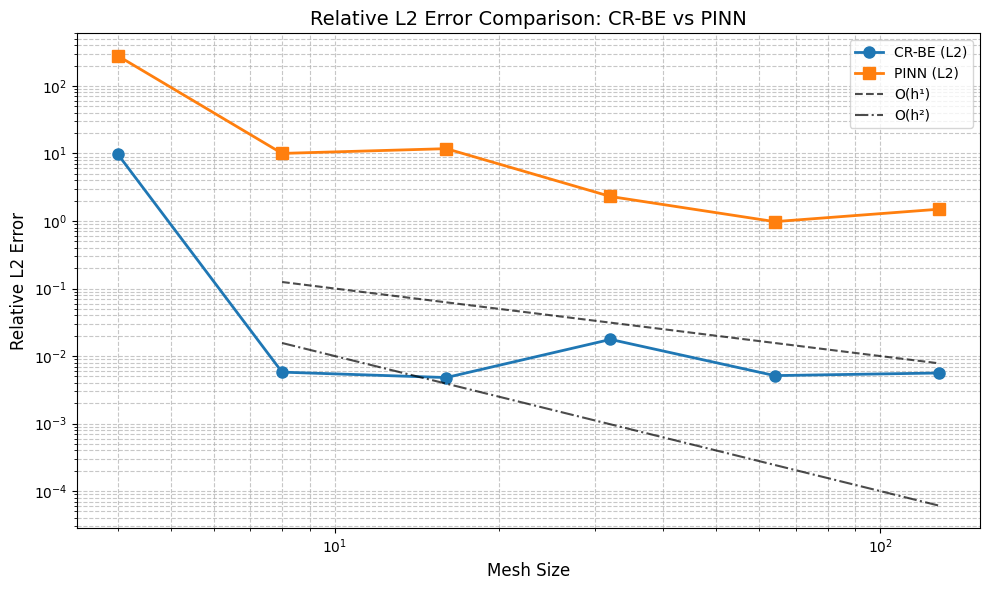

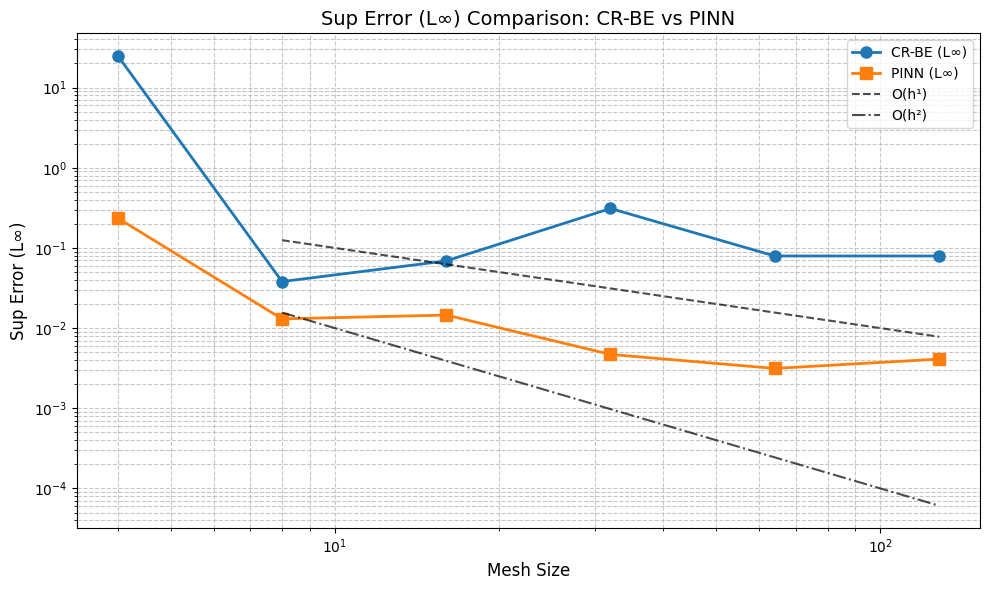

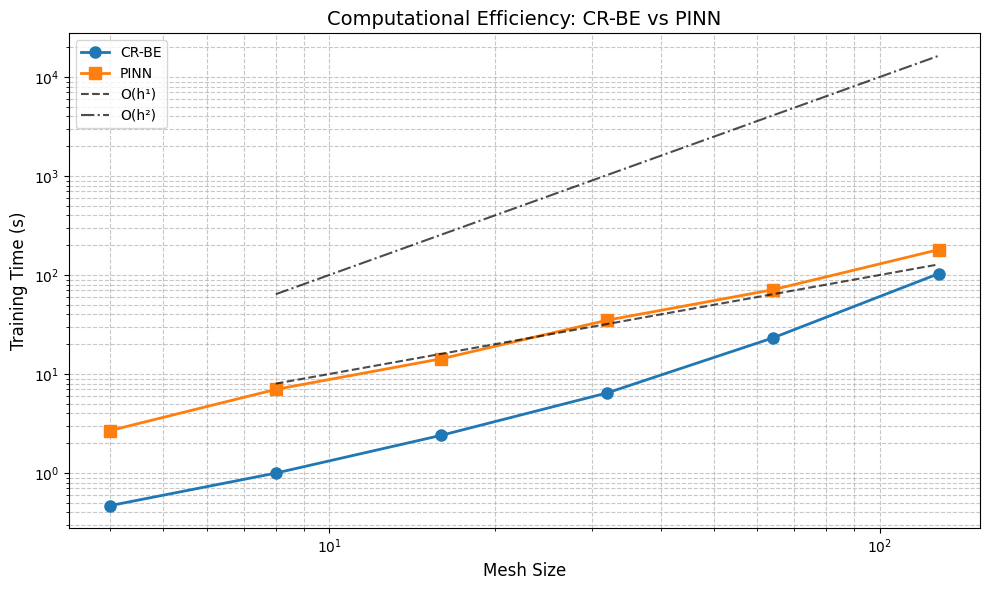

In [11]:

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
# Create a figure with two subplots for L2 and Linf errors
# plt.figure(figsize=(14, 10))

# Plot 1: L2 Error
plt.figure(figsize=(10, 6))

plt.loglog(df_crbe['mesh_size'], df_crbe['rel_l2_error'], 'o-', linewidth=2, markersize=8, label='CR-BE (L2)')
plt.loglog(df_pinn['mesh_size'], df_pinn['rel_l2_error'], 's-', linewidth=2, markersize=8, label='PINN (L2)')

# Add reference lines for convergence rates
x = np.array([8, 128])
plt.loglog(x, 1/x, 'k--', alpha=0.7, label='O(h¹)')
plt.loglog(x, 1/x**2, 'k-.', alpha=0.7, label='O(h²)')

plt.xlabel('Mesh Size', fontsize=12)
plt.ylabel('Relative L2 Error', fontsize=12)
plt.title('Relative L2 Error Comparison: CR-BE vs PINN', fontsize=14)
plt.grid(True, which="both", ls="--", alpha=0.7)
plt.legend(fontsize=10)

plt.tight_layout()
plt.savefig('error_comparison_loglog_l2.png', dpi=300, bbox_inches='tight')
plt.show()

# Plot 2: Linf Error
plt.figure(figsize=(10, 6))
plt.loglog(df_crbe['mesh_size'], df_crbe['max_error'], 'o-', linewidth=2, markersize=8, label='CR-BE (L∞)')
plt.loglog(df_pinn['mesh_size'], df_pinn['max_error'], 's-', linewidth=2, markersize=8, label='PINN (L∞)')

# Add reference lines for convergence rates
plt.loglog(x, 1/x, 'k--', alpha=0.7, label='O(h¹)')
plt.loglog(x, 1/x**2, 'k-.', alpha=0.7, label='O(h²)')

plt.xlabel('Mesh Size', fontsize=12)
plt.ylabel('Sup Error (L∞)', fontsize=12)
plt.title('Sup Error (L∞) Comparison: CR-BE vs PINN', fontsize=14)
plt.grid(True, which="both", ls="--", alpha=0.7)
plt.legend(fontsize=10)

plt.tight_layout()
plt.savefig('error_comparison_loglog_linf.png', dpi=300, bbox_inches='tight')
plt.show()

# Additional plot: Computational efficiency (train time vs mesh size)
plt.figure(figsize=(10, 6))
plt.loglog(df_crbe['mesh_size'], df_crbe['train_time'], 'o-', linewidth=2, markersize=8, label='CR-BE')
plt.loglog(df_pinn['mesh_size'], df_pinn['train_time'], 's-', linewidth=2, markersize=8, label='PINN')

# Add reference lines for computational complexity
plt.loglog(x, x**1, 'k--', alpha=0.7, label='O(h¹)')
plt.loglog(x, x**2, 'k-.', alpha=0.7, label='O(h²)')

plt.xlabel('Mesh Size', fontsize=12)
plt.ylabel('Training Time (s)', fontsize=12)
plt.title('Computational Efficiency: CR-BE vs PINN', fontsize=14)
plt.grid(True, which="both", ls="--", alpha=0.7)
plt.legend(fontsize=10)

plt.tight_layout()
plt.savefig('computational_efficiency_loglog.png', dpi=300, bbox_inches='tight')
plt.show()